# Hands-on Salmon

## Transcriptome

In this first section, we begin by defining a very simple transcriptome&mdash;a collection of RNA sequences that will serve as our model for testing RNA quantification.

We use a Python dictionary called `transcriptome` to store our transcript sequences which were designed with specific purposes.

- `txA` was designed to be very long and with region of high GC content.
- `txB` is much shorter without significant GC content.


In [1]:
transcriptome = {
    "txA": "GGTAATATTTAGGAGGATGTCTTACGGTCGCCGATGCCAGTAAAA" * 4
    + "GCGCGCTTACGCCGCTAATGCGGCGTCCGCGCGCAGCGCGCGCGC" * 6
    + "TACGTCATGAAAATCGACTTTTTTCTAGGGACTCGACAATTCGTA" * 4,
    "txB": "TCTCGACCGTGCCATATTGGAGTCAAT" * 4
    + "ATTGGTGGTGCAACTGGCTAGAAGGGG" * 4
    + "ATTGGGATCACAGTACGAAATTCGCTC" * 4,
}

## Basic generative model

Without incorporating sequencing biases.

In [2]:
import numpy as np

rng = np.random.default_rng()

In [3]:
def frag_len_dist(average_len: int = 150, variation: int = 30) -> int:
    """
    Generate a random fragment length based on a normal distribution.

    This function returns a fragment length sampled from a normal distribution
    with a given average length and variation. The minimum fragment length is
    capped at 25 to prevent extremely small values.

    Args:
        average_len: The mean fragment length. Defaults to 150.
        variation: The standard deviation of the fragment length. Defaults to 30.

    Returns:
        A randomly generated fragment length, with a minimum value of 25.
    """
    return max(25, int(rng.normal(average_len, variation)))

In [4]:
def simulate_rna_seq_reads(
    transcriptome: dict[str, str],
    alpha: list[int],
    num_reads: int = 1_000,
) -> list[tuple[str, int, str]]:
    """
    Simulate reads according to a generative model similar to Salmon.

    Args:
        transcriptome: A dictionary `{ transcript_id : transcript_sequence }`.
        alpha: Transcript abundance proportions of each transcript in the transcriptome.
        num_reads: Total number of reads (fragments) to simulate.
        frag_len_dist: A function that samples from the chosen fragment length
            distribution. E.g,. a lambda that calls np.random.
            If None, we'll assume a simple fixed length.
        rng: Random number generator for reproducibility. If None, a new default is created.

    Returns:
        A list of `(transcript_id, start_pos, fragment_seq)` for each simulated fragment.
    """

    # Gather transcript IDs and sequences
    tx_ids: list[str] = list(transcriptome.keys())
    tx_seqs = list(transcriptome.values())
    M = len(tx_ids)

    # Basic checks to ensure transcript abundances sum up to one.
    alpha = np.array(alpha, dtype=float)
    alpha /= alpha.sum()

    # List to store our reads.
    reads = []

    # Precompute transcript lengths
    tx_lengths = np.array([len(seq) for seq in tx_seqs])

    # For each read to simulate.
    while len(reads) < num_reads:
        # 1. Choose a transcript index i ~ Multinomial(alpha)
        i = rng.choice(M, p=alpha)

        # 2. Generate a random fragment (i.e., read) length
        L = frag_len_dist()

        # 3. Select a starting position
        #    We'll ensure there's room for a fragment of length L
        max_start = max(0, tx_lengths[i] - L)
        if max_start == 0:
            # If the transcript is too short, skip or try smaller L
            # In a real simulator, you'd handle corner cases more gracefully.
            continue

        # 4. Generate random start index
        start = rng.integers(low=0, high=max_start + 1)

        # 5. Extract the fragment sequence from the transcript and add it
        #    to our reads list.
        frag_seq = tx_seqs[i][start : start + L]
        reads.append((tx_ids[i], int(start), frag_seq))

    return reads

## Sampling reads

In [5]:
def get_read_counts(reads):
    counts = {}
    for read in reads:
        key = read[0]
        if key not in counts:
            counts[key] = 0
        else:
            counts[key] += 1

    # Sort keys
    ks = list(counts.keys())
    ks.sort()
    counts = {i: counts[i] for i in ks}
    return counts

In [6]:
# Transcript abundances
alphas = [0.4, 0.6]

simulated_reads = simulate_rna_seq_reads(transcriptome, alphas, num_reads=500)
read_counts = get_read_counts(simulated_reads)
print(f"Read counts: {read_counts}")

Read counts: {'txA': 220, 'txB': 278}


### Plotting reads



In [7]:
import matplotlib.pyplot as plt

In [8]:
def plot_read_positions(
    transcripts: dict[str, str], simulated_reads: list[tuple[str, int, str]]
):
    """
    Create a matplotlib figure with two axes (one for each transcript).
    For each transcript, a solid horizontal line is plotted representing the
    transcript's full length. Then, each simulated read for that transcript is shown
    as a horizontal line underneath, offset by 0.5 for each read.

    Args:
        transcripts: Dictionary mapping transcript IDs (e.g., "txA", "txB")
            to their sequences.
        simulated_reads: Each tuple should be of the form
            `(transcript_id, start_position, fragment_sequence)`.

    Returns
        The generated figure.
    """
    # Create one subplot per transcript (assuming two transcripts: txA and txB)
    tx_ids = list(transcripts.keys())
    fig, axs = plt.subplots(nrows=1, ncols=len(tx_ids), sharey=True)

    for ax, tx in zip(axs, tx_ids):
        seq = transcripts[tx]
        tx_length = len(seq)
        # Draw the full transcript as a thick horizontal line at y=0.
        ax.hlines(
            y=0,
            xmin=0,
            xmax=tx_length,
            color="#03045e",
            linewidth=5,
            label="Transcript",
        )

        # Filter reads for the current transcript.
        tx_reads = [read for read in simulated_reads if read[0] == tx]

        # For each read, plot a horizontal line offset downward by 0.5 for each read.
        for i, (_, start, frag_seq) in enumerate(tx_reads):
            read_length = len(frag_seq)
            # Each read is drawn at y = -0.5*(i+1) (so they stack below the transcript)
            y_pos = -2 + -1.0 * (i + 1)
            ax.hlines(
                y=y_pos,
                xmin=start,
                xmax=start + read_length,
                color="#00b4d8",
                linewidth=2,
            )

        ax.set_title(f"Transcript {tx}")
        ax.set_xlim(0, tx_length)
        ax.set_yticks([])
        ax.set_xlabel("Position along transcript")
        ax.set_ylabel("Reads")
        ax.invert_yaxis()

    plt.tight_layout()
    return fig

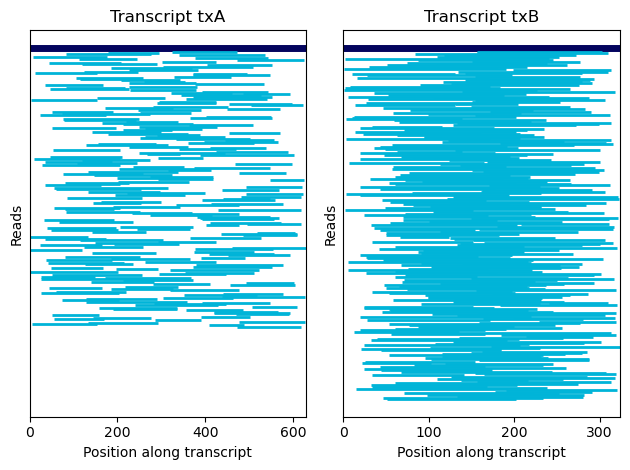

In [9]:
fig = plot_read_positions(transcriptome, simulated_reads)
plt.show()

## Biases

In building our generative model for RNA quantification, our goal is to simulate the way real RNA-seq experiments capture data.
In actual experiments, several factors introduce biases in how reads are sampled from transcripts.
By explicitly modeling these biases, we can generate synthetic data that more closely mirrors real-world scenarios, thereby allowing us to better test and understand the downstream quantification algorithms.

### Positional bias

In practice, RNA-seq protocols do not sample uniformly along the entire length of a transcript.
Often, fragments originating from the middle of a transcript are more likely to be sequenced, while those at the very beginning or end might be underrepresented.
This can be due to biases in the fragmentation process or in the efficiency of reverse transcription.


- By calculating the fraction of the transcript where the read begins, we normalize the position regardless of transcript length. This makes our function generally applicable.
- The exponential function `np.exp(-5.0 * (frac - 0.5) ** 2)` creates a bell-shaped curve centered around the midpoint (0.5). The constant `5.0` controls the sharpness of the decay, ensuring that positions near the ends are heavily penalized. This approach captures the idea that the likelihood of sampling a fragment drops off as you move away from the center.


In [10]:
def positional_bias_example(start_index, transcript_length):
    # fraction along the transcript
    frac = start_index / transcript_length
    # For instance, heavily penalize extremes:
    # near 0% => less likely, near 100% => less likely
    # peak in the middle
    return np.exp(-5.0 * (frac - 0.5) ** 2)

GC content plays a significant role in sequencing efficiency. Fragments with very low or very high GC content can be problematic during sequencing, resulting in their underrepresentation in the final dataset. Mid-range GC content, around 50%, is often optimal for many sequencing platforms.

**Why This Implementation?**

- Similar to the positional bias, this function uses an exponential decay centered around 0.5. This reflects the experimental observation that fragments with a GC fraction near 50% are sequenced more reliably.
- The exponential decay again provides a smooth, continuous way to reduce the likelihood of sampling fragments that deviate too far from the optimal GC content. This smooth curve is a reasonable approximation for the gradual decrease in sequencing efficiency observed in many studies.


In [11]:
def gc_bias_example(gc_frac):
    # Suppose we strongly favor mid-range GC
    return np.exp(-5 * (gc_frac - 0.5) ** 2)

The function `simulate_rna_seq_reads` generates synthetic reads from a given set of transcripts using a generative model inspired by tools like Salmon.
The model integrates multiple factors—such as transcript abundance, fragment length variability, positional bias, and GC-content bias—to approximate real sequencing experiments.

In [12]:
import numpy as np


def simulate_rna_seq_reads_with_biases(
    transcripts: dict[str, str],
    alpha: list[int],
    num_reads: int = 10_000,
    frag_len_dist=None,
    pos_bias=None,
    gc_bias=None,
    rng=None,
) -> list[tuple[str, int, str]]:
    r"""
    Simulate reads according to a generative model similar to Salmon.

    Args:
        transcripts: A dictionary `{ transcript_id : transcript_sequence }`.
        alpha: Transcript abundance proportions (must sum to 1).
        num_reads: Total number of reads (fragments) to simulate.
        frag_len_dist: A function that samples from the chosen fragment length distribution.
            E.g. a lambda that calls np.random.  If None, we’ll assume a simple fixed length.
        pos_bias: Position bias function
        gc_bias: A function that, given GC content of a fragment, returns a multiplicative bias.
        rng: Random number generator for reproducibility. If None, a new default is created.

    Returns:
        A list of (transcript_id, start_pos, fragment_seq) for each simulated fragment.
    """
    # Seed the random number generator
    if rng is None:
        rng = np.random.default_rng()

    # Gather transcript IDs and sequences
    tx_ids: list[str] = list(transcripts.keys())
    tx_seqs = list(transcripts.values())
    M = len(tx_ids)

    # Basic checks
    alpha = np.array(alpha, dtype=float)
    alpha /= alpha.sum()

    # Default fragment length distribution if none is given
    if frag_len_dist is None:
        # Suppose we always sample fragments of length ~ 150 plus some noise
        def frag_len_dist():
            return max(25, int(rng.normal(150, 30)))

    reads = []

    # Precompute transcript lengths
    tx_lengths = np.array([len(seq) for seq in tx_seqs])

    # For each read to simulate:
    while len(reads) < num_reads:
        # 1. Choose a transcript index i ~ Multinomial(alpha)
        i = rng.choice(M, p=alpha)

        # 2. Sample fragment length
        L = frag_len_dist()

        # 3. Select a start position
        #    We'll ensure there's room for a fragment of length L
        max_start = max(0, tx_lengths[i] - L)
        if max_start == 0:
            # If the transcript is too short, skip or try smaller L
            # In a real simulator, you'd handle corner cases more gracefully.
            continue
        start = rng.integers(low=0, high=max_start + 1)

        # 4. Extract the fragment sequence from the transcript
        frag_seq = tx_seqs[i][start : start + L]

        # Initialize bias factor
        bias_factor = 1

        # 5. Compute positional bias
        if pos_bias:
            bias_factor *= pos_bias(start, len(tx_seqs[i]))

        # 6. Compute GC bias (entire fragment)
        if gc_bias:
            gc_frac = (frag_seq.count("G") + frag_seq.count("C")) / float(len(frag_seq))
            bias_factor *= gc_bias(gc_frac)

        # 7. Accept or reject fragment according to bias_factor.
        #    A typical generative approach would weight transcripts by bias_factor,
        #    but here we’ll do a simple “probabilistic acceptance” approach:
        #    e.g., if bias_factor < 0.5, we might reject half the time, etc.
        #    Or we can simply store the factor to re-weigh probabilities later.
        if rng.random() < bias_factor:
            # Store the read
            reads.append((tx_ids[i], int(start), frag_seq))

    return reads

In [13]:
simulated_reads_with_biases = simulate_rna_seq_reads_with_biases(
    transcriptome,
    alphas,
    num_reads=500,
    frag_len_dist=frag_len_dist,
    pos_bias=positional_bias_example,
    gc_bias=gc_bias_example,
)

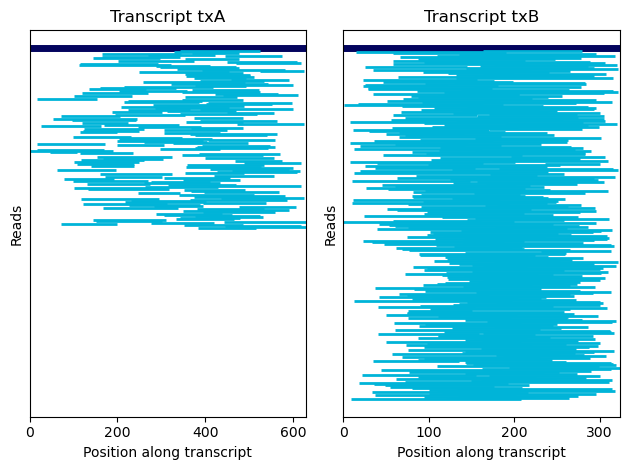

In [14]:
fig = plot_read_positions(transcriptome, simulated_reads_with_biases)
plt.show()

## Quantification

### Effective biases

In RNA-seq data simulation and quantification, biases such as positional bias—where fragments are more or less likely to be sampled from certain parts of a transcript—and GC bias—where the GC content of fragments affects their probability of being sequenced—can significantly impact the observed read counts.
Both simulation and real quantification methods, such as Salmon, must account for these biases to accurately infer transcript abundances.

In our simulation process, we begin by sampling a transcript based on its relative abundance, represented by the vector **α**.
Once a transcript is chosen, a fragment length is sampled from either a fixed length or a specified distribution. A start position is then selected within the transcript so that the fragment fits completely. At this point, two bias functions are applied. The positional bias adjusts the likelihood of fragment sampling based on its location within the transcript, while the GC bias adjusts the likelihood according to the fragment's GC content. After computing these biases, the fragment is accepted or rejected probabilistically, based on the product of the bias factors. The final result is a set of simulated reads that reflects both the original transcript proportions and the influence of sequencing biases.

When we attempt to reverse the simulation and estimate the original transcript proportions from the simulated reads, we encounter the challenge that the observed read counts have already been influenced by these biases. To address this, we estimate what we call an "effective bias" for each transcript. This effective bias factor, often denoted as pᵢ for transcript *i*, represents the average influence of the biases on the likelihood of sampling a fragment from that transcript. We approximate this factor using Monte Carlo sampling over all possible valid fragments from each transcript. For each valid fragment, we calculate the product of the bias functions and then average these values over many samples. This approach provides a correction factor that accounts for the average impact of biases on fragment generation.

The effective bias factor is then incorporated into a likelihood model where the probability of observing a read from transcript *i* is proportional to the product of the transcript's abundance (α[i]) and its effective bias (pᵢ). In other words, even if a transcript has a high inherent abundance, it may appear underrepresented in the observed reads if its effective bias is low because the sequencing process makes fragments from that transcript less likely to be generated.


In [15]:
def estimate_effective_bias(
    transcripts: dict[str, str],
    frag_len_dist,
    pos_bias,
    gc_bias,
    n_samples=1000,
):
    """
    Estimate the effective bias factor p_i for each transcript i.

    The effective bias is computed by Monte Carlo sampling valid fragments from each
    transcript and averaging the product of the positional and GC bias.

    Parameters:
        transcripts: Dictionary mapping transcript ID to sequence.
        frag_len_dist: Function that returns an integer fragment length.
        pos_bias : Function (start, transcript_length) -> float.
        gc_bias : function
            Function (gc_frac) -> float.
        n_samples : int
            Number of Monte Carlo samples per transcript.
        rng : np.random.Generator, optional
            Random number generator.

    Returns:
        Dictionary mapping transcript ID to effective bias p_i.
    """
    eff_bias = {}
    for tx_id, seq in transcripts.items():
        L_tx = len(seq)
        bias_values = []
        for _ in range(n_samples):
            L = frag_len_dist()
            # Only sample if the transcript is long enough for this fragment.
            if L >= L_tx:
                continue  # Skip this sample if transcript is too short.
            max_start = L_tx - L
            start = rng.integers(low=0, high=max_start + 1)
            frag_seq = seq[start : start + L]
            b = 1.0
            if pos_bias:
                b *= pos_bias(start, L_tx)
            if gc_bias:
                # Compute GC fraction in the fragment.
                gc_count = frag_seq.count("G") + frag_seq.count("C")
                gc_frac = gc_count / float(len(frag_seq))
                b *= gc_bias(gc_frac)
            bias_values.append(b)
        # If no valid fragments were sampled, set effective bias to 0.
        if bias_values:
            eff_bias[tx_id] = float(np.mean(bias_values))
        else:
            eff_bias[tx_id] = 0.0
    return eff_bias

In [16]:
def negative_log_likelihood(alpha, counts, effective_bias, tx_ids):
    """
    Compute the negative log likelihood given the candidate alpha.

    The predicted probability for transcript i is:
        p_i_pred = (alpha[i] * effective_bias[i]) / sum_j (alpha[j] * effective_bias[j])

    We assume the observed counts follow a multinomial distribution.

    Parameters:
        alpha : np.ndarray
            Candidate alpha vector (should sum to 1).
        counts : dict[str, int]
            Observed read counts for each transcript.
        effective_bias : dict[str, float]
            Effective bias factors for each transcript.
        tx_ids : list[str]
            Ordered list of transcript IDs.

    Returns:
        nll : float
            Negative log likelihood.
    """
    # Compute denominator: sum over transcripts
    numerators = np.array(
        [alpha[i] * effective_bias[tx_id] for i, tx_id in enumerate(tx_ids)]
    )
    denom = np.sum(numerators)
    if denom == 0:
        return np.inf
    # Compute predicted probabilities per transcript.
    p_pred = numerators / denom
    # Build observed frequency vector (using the order tx_ids).
    obs = np.array([counts.get(tx_id, 0) for tx_id in tx_ids])
    # To avoid log(0), add a small epsilon.
    epsilon = 1e-12
    nll = -np.sum(obs * np.log(p_pred + epsilon))
    return nll

In [17]:
def read_likelihood_for_transcript(
    read, transcript_seq, pos_bias, gc_bias, epsilon=1e-6
):
    """
    Compute the likelihood of a read given a transcript.

    The function looks for the read's fragment (read[2]) in the transcript sequence.
    If found, it uses the alignment start position to compute a positional bias and computes
    GC bias from the read fragment. If not found, returns a small epsilon.

    Parameters:
        read : tuple
            A tuple (true_tx, start, frag_seq) for the read.
        transcript_seq : str
            Sequence of the transcript.
        pos_bias : function
            Function taking (start_index, transcript_length) and returning a bias value.
        gc_bias : function
            Function taking GC fraction (a float) and returning a bias value.
        epsilon : float
            Background likelihood if the read does not align.

    Returns:
        likelihood : float
            Likelihood of observing the read given the transcript.
    """
    frag_seq = read[2]
    # Look for the fragment in the transcript.
    alignment_start = transcript_seq.find(frag_seq)
    if alignment_start == -1:
        return epsilon
    else:
        bias_val = pos_bias(alignment_start, len(transcript_seq))
        gc_count = frag_seq.count("G") + frag_seq.count("C")
        gc_frac = gc_count / float(len(frag_seq)) if len(frag_seq) > 0 else 0.0
        return bias_val * gc_bias(gc_frac)

In [18]:
def estimate_alpha_em(
    transcripts, simulated_reads, pos_bias, gc_bias, max_iter=100, tol=1e-6
):
    """
    Estimate transcript proportions using an EM algorithm that considers
    the likelihood of each read aligning to each transcript, where the likelihood
    incorporates positional and GC bias.

    Args:
        transcripts : dict[str, str]
            Dictionary mapping transcript IDs to sequences.
        simulated_reads : list of tuples
            Each tuple is (true_transcript_id, start_pos, fragment_seq).
        pos_bias : function
            Positional bias function.
        gc_bias : function
            GC bias function.
        max_iter : int
            Maximum number of EM iterations.
        tol : float
            Convergence tolerance.

    Returns:
        Estimated transcript proportions.
    """
    tx_ids = list(transcripts.keys())
    M = len(tx_ids)
    N = len(simulated_reads)

    # Initialize alpha uniformly.
    alpha = np.ones(M) / M

    for iteration in range(max_iter):
        # E-step: compute responsibilities for each read.
        responsibilities = np.zeros((N, M))
        for i, read in enumerate(simulated_reads):
            likelihoods = np.zeros(M)
            for j, tx_id in enumerate(tx_ids):
                L = read_likelihood_for_transcript(
                    read, transcripts[tx_id], pos_bias, gc_bias
                )
                likelihoods[j] = alpha[j] * L
            # Normalize responsibilities for this read.
            total = likelihoods.sum() + 1e-12  # prevent division by zero
            responsibilities[i, :] = likelihoods / total

        # M-step: update alpha based on responsibilities.
        new_alpha = responsibilities.sum(axis=0) / N

        # Check for convergence.
        if np.linalg.norm(new_alpha - alpha) < tol:
            alpha = new_alpha
            break
        alpha = new_alpha

    est_alpha = {tx_id: alpha[j] for j, tx_id in enumerate(tx_ids)}
    return est_alpha

In [19]:
# Estimate transcript proportions using the EM algorithm.
est_alpha = estimate_alpha_em(
    transcriptome, simulated_reads_with_biases, positional_bias_example, gc_bias_example
)
print("Estimated transcript proportions")
for tx, a in est_alpha.items():
    print(f"  {tx}: {a:.4f}")

Estimated transcript proportions
  txA: 0.3380
  txB: 0.6620
